
# Exploring the Relationship between Air Quality and COVID-19 Infections
For this project, our goal is to investigate a **possible** relationship between Air Quality and COVID-19 Infection Rates. To that end, we merged an Air Quality dataset with a COVID-19 dataset, performed preprocessing before and after the merge, trained a regression model on the merged dataset, and performed predictions to test the accuracy of our model.

As an exploration, we attempted to exhaust all relevant regression models whose parameters have been appropriately tuned (if possible), from Support Vector Machines to Linear Regressors (we settled with the latter). All relevant preprocessing steps, from data cleaning, feature renaming and imputation, to pruning, feature selection and standardization, have also been taken.

To simplify our scope, we have focused only on California Air Quality and COVID-19 datasets, putting a geographical restriction on our approach. The time-series data were sourced directly from the United States Environmental Protection Agency (EPA) and the California State Government respectively. This choice of going abroad is motivated by the difficulty of procuring day-to-day Air Quality and COVID-19 data from the Philippines (data availability and accessibility is still a big issue of our government agencies). We require day-to-day data for a more granular training set.

Because our preprocessed dataset only holds continuous quantitative values, regression is the most appropriate modeling approach.

**Important:** Because this is an exploratory project, we are not absolutely certain that there exists a significant relationship between Air Quality and COVID-19 datasets. Furthermore, our results, significant or not, can only lend support to hypotheses surrounding Air Quality and COVID-19. And THIS is why context matters, especially in something as daring as science and on something were data updates tend to be irregular (COVID-19 cases, deaths, tests, vaccines, etc.).

#### Terminology
- **Dataset A** - the dataset containing day-to-day California Air Quality data based on raw pollutant measures, from 2020-2022.
Raw source: [https://www.epa.gov/outdoor-air-quality-data/download-daily-data](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)
- **Dataset B** - the dataset containing day-to-day New York COVID-19 cases data, from 2020 to 2022.
Raw source: [https://data.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state](https://data.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state)

**Quick Notes:** For preprocessing, we’ve dropped category columns, dropped a feature with no significant relationship with our target vector ‘New Cases’, performed imputation to estimate NaNs and fill them up instead of wholesale dropping rows with NaNs (wasted samples), and then removed outliers (and more). Feature scaling for just the Air QUality dataset was also attempted but skipped after worsening the fit, but feature scaling for the merged datasets was retained. With this, our linear regression model gave us an R2 score of 63.4% which we believe is good enough for an exploratory project (merging 2 government datasets instead of just getting 1 from Kaggle), and this is just how Science works. We keep random_state = 1 for IterativeImputer()and train_test_split() all throughout.

## Preprocessing: Air Quality Dataset (Dataset A)
Let us look at the samples, features, and other details regarding the dataset so that we better know what we're dealing with. But first, we need to import the datasets into manipulable dataframes. Note: We've already checked the datasets prior to downloading them, but we include this section for completeness.

Note that the reason we started with dataset fragments for Dataset A is because downloading the datasets by year, by state, and then by pollutant type is the only way to do so in the EPA website.

### Importing and Assessing Dataset A
In this section, we will import the pollutant-by-pollutant and then year-by-year fragments (after accumulation) of Dataset A, namely dataA2020, dataA2021, and dataA2022.
Next, we'll make preliminary observations on them, and then concatenate them together to form our desired dataset, dataA, that goes from the start of the pandemic on 2020 until the end of 2022.

In [2238]:
# Set Jupyter Notebook to clear all workspace variables before the next complete run
%reset -f
# Set Jupyter Notebook to print out all interactions.
# This enables displaying the contents of a variable or function return value from any part of the code and
# not just at the end of code block.
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

# Initialize accumulator datasets using CO (carbon dioxide) datasets (these are temporary)
# NOTE: Dataset fragments are all in './CAdata/'
datadir = 'CAdata/'
colidx = [0,2,4,17]                             # column indexes to use (already looked at CA datasets)
innerkeys = ['Date', 'Site ID', 'COUNTY']       # Merge on Date, Site ID, and COUNTY

# Because date is an important factor to us, as we read the CSV files, we immediately parse their dates
# Note that colidx is applied here, which cherry picks the columns to use from the datasets
# wherein the columns contain extraneous information of coordinates and site name.
dataA2020 = pd.read_csv(datadir + 'ca-2020-co.csv', parse_dates=True, usecols=colidx)
dataA2021 = pd.read_csv(datadir + 'ca-2021-co.csv', parse_dates=True, usecols=colidx)
dataA2022 = pd.read_csv(datadir + 'ca-2022-co.csv', parse_dates=True, usecols=colidx)

# Iterate through the CAdata directory using os.scandir, and then get all the datasets there
# Merge the remaining datasets other than ca-year-co to dataAyear
with os.scandir(datadir) as datasets:
    for dataset in datasets:
        if dataset.is_file() and 'co' not in dataset.name and 'ca' in dataset.name:
            temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
            if '2020' in dataset.name:
                dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
            elif '2021' in dataset.name:
                dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
            elif '2022' in dataset.name:
                dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

We used outer join for the merge in order to increase the number of records that we have, especially because the volume of records is crucial for training regressors. We'll handle the NaN values later on with imputation.

Now let's take a peek at the dataset A year-by-year fragments. As expected, use of outer join has left us with a lot of NaN values, but thankfully, those values are properly surrounded by existing values on a time-series, hence imputation would be appropriately applied to this. We also find several columns that we could still drop.

Moreover, we see that the column names could still be cleaned up for easier interpretation and story-telling, and we could add back the respective units of the pollutant columns that we have not included in the cherry picking with `colidx`.

In [2239]:
# At this point, dataA2020, dataA2021, and dataA2022 have accumulated the CA dataset year fragments.
dataA2020.head()
dataA2021.head()
dataA2022.head()

,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,01/01/2020,60010009,0.7,Alameda,21.3,0.020,NaN,NaN,13.1,NaN
1,01/02/2020,60010009,0.7,Alameda,29.4,0.011,NaN,NaN,7.6,NaN
2,01/03/2020,60010009,0.9,Alameda,31.9,0.007,NaN,NaN,15.0,NaN
3,01/04/2020,60010009,0.8,Alameda,23.0,0.024,NaN,NaN,9.5,NaN
4,01/05/2020,60010009,0.7,Alameda,22.9,0.030,NaN,NaN,6.1,NaN


,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,01/01/2021,60010009,0.7,Alameda,25.0,0.019,NaN,NaN,14.2,NaN
1,01/02/2021,60010009,0.7,Alameda,25.2,0.014,NaN,NaN,9.4,NaN
2,01/03/2021,60010009,0.7,Alameda,21.9,0.016,NaN,NaN,13.7,NaN
3,01/04/2021,60010009,0.7,Alameda,22.2,0.030,NaN,NaN,8.2,NaN
4,01/05/2021,60010009,0.6,Alameda,19.1,0.023,NaN,NaN,6.6,NaN


,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,01/01/2022,60010009,0.7,Alameda,22.9,0.028,NaN,NaN,13.2,NaN
1,01/02/2022,60010009,0.6,Alameda,25.5,0.021,NaN,NaN,8.2,NaN
2,01/03/2022,60010009,0.6,Alameda,20.1,0.029,NaN,NaN,3.8,NaN
3,01/04/2022,60010009,0.4,Alameda,23.1,0.025,NaN,NaN,3.1,NaN
4,01/05/2022,60010009,0.4,Alameda,29.2,0.023,NaN,NaN,4.7,NaN


For peace of mind, we again parse the `Date` column into date.

The initial datasets then drop the `Site ID` column and then groups them by `Date`.
- The index column is then conveniently set to `Date`.
- We tried grouping by both median and mean, and **mean** worked best.
- We took the **mean of the measures** from all the air quality sampling sites across the state of California, assuming that this would provide a pretty good approximation of the air quality for the entire state.
- We also require data A to be grouped by `Date` in anticipation of COVID-19 Data B whose records are primarily pegged to the `Date` (and the `State`) columns.
- We note that in a single day, there could be multiple records from different Site IDs, but only one record from the same Site ID, and we discovered this from peeking at the dataset.

We deem this kind of grouping acceptable because the measures are taken from the same state and from the same populated areas.

These datasets now contain raw air pollutant measures as well as the date in which they are recorded.

Moreover, we also look at time-series plots of the datasets, from which we observe that there are huge fluctuations in Air Quality measures. This indicates that we'll have to do feature scaling on the data to smooth it later on.

Dataset A fragments before grouping:


,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,2020-01-01,60010009,0.7,Alameda,21.3,0.020,NaN,NaN,13.1,NaN
1,2020-01-02,60010009,0.7,Alameda,29.4,0.011,NaN,NaN,7.6,NaN
2,2020-01-03,60010009,0.9,Alameda,31.9,0.007,NaN,NaN,15.0,NaN
3,2020-01-04,60010009,0.8,Alameda,23.0,0.024,NaN,NaN,9.5,NaN
4,2020-01-05,60010009,0.7,Alameda,22.9,0.030,NaN,NaN,6.1,NaN


,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,2021-01-01,60010009,0.7,Alameda,25.0,0.019,NaN,NaN,14.2,NaN
1,2021-01-02,60010009,0.7,Alameda,25.2,0.014,NaN,NaN,9.4,NaN
2,2021-01-03,60010009,0.7,Alameda,21.9,0.016,NaN,NaN,13.7,NaN
3,2021-01-04,60010009,0.7,Alameda,22.2,0.030,NaN,NaN,8.2,NaN
4,2021-01-05,60010009,0.6,Alameda,19.1,0.023,NaN,NaN,6.6,NaN


,Date,Site ID,Daily Max 8-hour CO Concentration,COUNTY,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,2022-01-01,60010009,0.7,Alameda,22.9,0.028,NaN,NaN,13.2,NaN
1,2022-01-02,60010009,0.6,Alameda,25.5,0.021,NaN,NaN,8.2,NaN
2,2022-01-03,60010009,0.6,Alameda,20.1,0.029,NaN,NaN,3.8,NaN
3,2022-01-04,60010009,0.4,Alameda,23.1,0.025,NaN,NaN,3.1,NaN
4,2022-01-05,60010009,0.4,Alameda,29.2,0.023,NaN,NaN,4.7,NaN


Dataset A fragments after grouping by Date (note Date as index):


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2020-01-01,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
2020-01-02,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2020-01-03,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
2020-01-04,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
2020-01-05,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2021-01-01,0.665000,22.645000,0.030844,0.021500,16.342105,14.104615,0.950000
2021-01-02,0.657895,22.458475,0.028398,0.010000,18.055556,12.370199,0.820455
2021-01-03,0.663158,21.499145,0.029293,0.008000,19.090909,14.147368,0.720930
2021-01-04,0.709740,27.123196,0.029920,0.006776,24.549550,14.059341,0.725000
2021-01-05,0.711842,27.218966,0.026878,0.027000,17.977528,12.394079,0.892857


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2022-01-01,0.556000,21.297581,0.034212,NaN,14.615385,10.865663,0.541860
2022-01-02,0.552688,25.704167,0.032208,NaN,13.600000,8.823744,0.730508
2022-01-03,0.700000,28.399194,0.030789,NaN,18.560345,8.744785,0.925581
2022-01-04,0.762667,29.063934,0.029168,NaN,21.894737,9.966061,1.142857
2022-01-05,1.031157,41.096725,0.022163,0.01166,35.697400,16.667782,1.211684


Show plots of the obtained datasets


<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

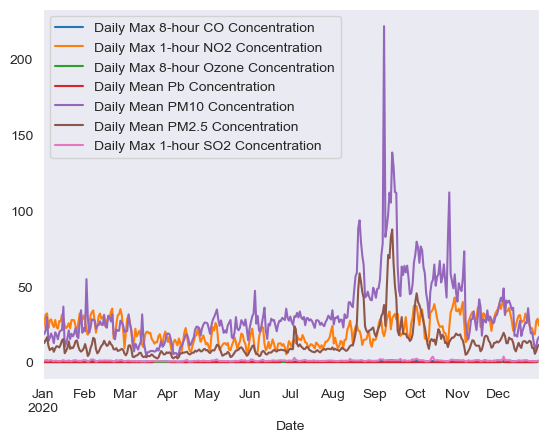

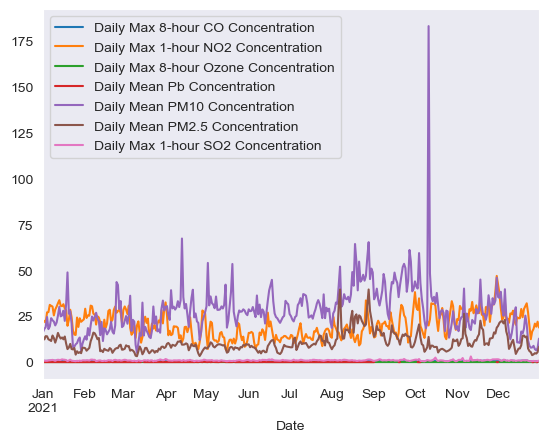

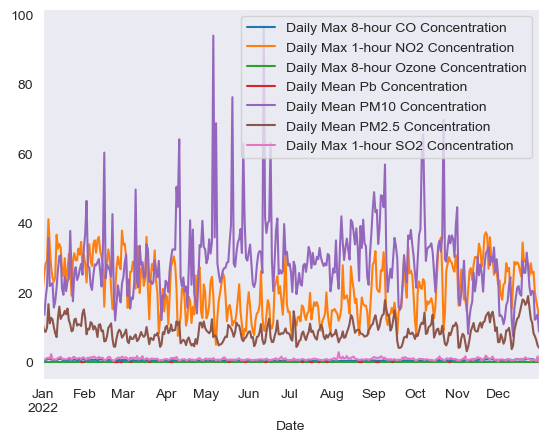

In [2240]:
# Parse Date to date
dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])
print("Dataset A fragments before grouping:")
dataA2020.head()
dataA2021.head()
dataA2022.head()

# Group data by Date and Site ID, then by Date again to remove the Site ID feature
# Result would be mean measurements per day
dataA2020 = dataA2020.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
dataA2021 = dataA2021.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
dataA2022 = dataA2022.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
print("Dataset A fragments after grouping by Date (note Date as index):")
dataA2020.head()
dataA2021.head()
dataA2022.head()

print("Show plots of the obtained datasets")
dataA2020.plot()
dataA2021.plot()
dataA2022.plot()

### Merging of Temporary Datasets into one dataset (dataA2020 + dataA2021 + dataA2022 = dataA)
This is where Air Particles concentration from each year are merged into one whole dataset (2020-2023) which will be used later on.

In [2241]:
dataA = pd.concat([dataA2020, dataA2021, dataA2022])    # Combine the three datasets
# Concatenation just stitches together the years, so effectively we'll now have a complete measurement of air pollutants from 2020-01-01 to 2022-12-31.
print("Combined dataset (Date set as index):")
dataA

Combined dataset (Date set as index):


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2020-01-01,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
2020-01-02,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2020-01-03,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
2020-01-04,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
2020-01-05,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667
...,...,...,...,...,...,...,...
2022-12-27,0.814925,25.993333,0.027554,NaN,20.254386,8.294737,0.761111
2022-12-28,0.409756,20.100000,0.030041,NaN,12.185185,7.471809,0.555769
2022-12-29,0.392063,17.505660,0.028821,0.004000,12.609091,6.344000,0.361765


### [Skip] Feature Scaling: Standardization for dataA
As mentioned earlier, we have a pretty explosive fluctuation of samples within dataA, hence let us standardize it so that imputation would also behave correctly: [https://scikit-learn.org/stable/modules/preprocessing.html](https://scikit-learn.org/stable/modules/preprocessing.html). Standardization is chosen instead of normalization because we need greater freedom on the bounds of the treated and the resulting data.

Using MinMaxScaler() also helps us reach the many outliers in our air quality data (imagine the contrast between wildfire season and ambient air quality in California) and bound them to [0, 1].

[Skip]: This step has to be skipped as it led to poorer R2 scores (from 63.4% down to 34.8 percent). Let's just retain the pretty plot. But NOTE that feature scaling was done on the merged dataset before the modeling.

<AxesSubplot:xlabel='Date'>

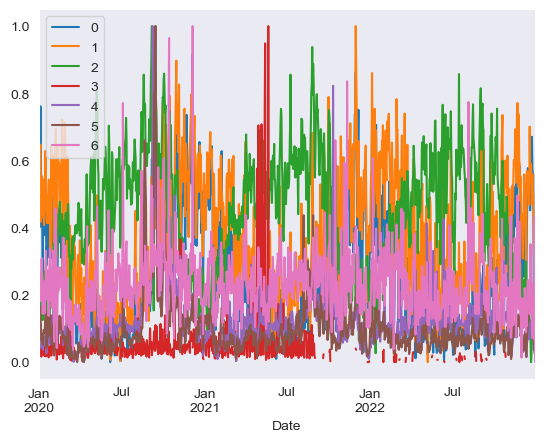

In [2242]:
from sklearn.preprocessing import MinMaxScaler

# We preserve the index from the scaler
date = dataA.index
pd.DataFrame(MinMaxScaler().fit_transform(dataA), index=date).plot()
# dataA.plot()
# dataA

### Column Renaming for dataA
This is where we shorten the name of each air contaminants to a corresponding concise name that's as descriptive as possible along with their corresponding units. This also brings back the correct column names after the scaling.

In [2243]:
new_names = ['CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

print("dataA columns renamed:")
dataA.head()

dataA columns renamed:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
2020-01-02,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2020-01-03,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
2020-01-04,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
2020-01-05,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


### Checking for NaN values in dataA
This is where we checked the null values on the dataset and decide what actions are needed to be done. In this case, imputing is the best course of action because a third of the entries contain NaN values, and dropping all those would drastically reduce our sample size.

In [2244]:
import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

A: Number of entries with null values: 359
A: Number of entries: 1096


### Imputation of dataA
We then use SKLearn's experimental iterative imputer to estimate the missing values. This is hyperparameter tunable:
- We tried tuning the estimator used by the imputer.
- We tried changing the initial strategy.

After this section, there would be no more entries with missing values.

Note that we've also tested just dropping the entries with missing values and we consistently got poorer R2 scores.

In [2245]:
# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Other estimators (estimator = func()) to try
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize imputer
# NOTE: DIFFERENT ESTIMATORS WERE TRIED HERE, from DecisionTreeRegressor() to KNeighborsRegressor()
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())

# Perform imputation (note that convergence was quickly reached, indicating a good imputation)
dataA[:] = imp.fit_transform(dataA)

print("After imputation:")
dataA.head()
print("A: Number of entries with null values after impute:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

[IterativeImputer] Completing matrix with shape (1096, 7)
[IterativeImputer] Change: 0.015027354506753809, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Early stopping criterion reached.
After imputation:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
2020-01-02,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2020-01-03,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
2020-01-04,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
2020-01-05,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


A: Number of entries with null values after impute: 0
A: Number of entries: 1096


## Preprocessing: COVID-19 Infections Dataset (Dataset B)
We perform similar preprocessing steps for Dataset B that we've done for Dataset A, and also do some more preprocessing for Dataset A.
**Remark:** There would be more preprocessing after the merging of Dataset A with Dataset B.

### Importing and Assessing Dataset B (dataB)
This is the second dataset that we are going to use alongside dataset A. This contains the COVID-19 data, specifically the date when it was recorded, the state that it came from, the total covid cases, confirmed covid cases, and the sum of the new cases that arose that day.

**Terminology:** Note that total covid cases is the sum of confirmed covid cases + probable covid cases, which are incrementing at different rates.

In this dataset, we limit our data to the state of California (CA). Then, we used the date when the data was gathered as the index of the dataset. After that, we filtered dataset A's temporal range with the date available in dataset B.

Finally, we checked the null values of dataset B to determine whether we need to impute or not. In this case, we don't need to impute since it has clean data (zero NaNs).

**IMPORTANT:** Here we must realize that both air quality and COVID-19 datasets are very prone to spikes. Again, imagine wildfires or smogs for air quality, and surges and surprise data dumps for COVID-19. Let us keep this in mind as we proceed.

In [2246]:
colidx = [0,1,2,3,5,6]     # column indexes to use (based on preemptively looking at dataB)
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)

# ASSUMPTION: Let us treat all probable cases as an actual new case.
# We can do this because there are many dates where there are zero infections in dataB, but science would say that there's always background transmission going on, especially in the case of COVID-19 which is airborne and isn't always symptomatic.
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

# Rename dataB columns to names comparable to dataA
# Note that we designated new_case + pnew_case as the column 'Sum New Cases'
dataB.columns = ['Date', 'State', 'Total Cases', 'Confirmed Cases', 'Sum New Cases']

# Filter dataset B to just the state of CA
dataB = dataB[dataB['State'] == 'CA']
dataB.head()

,submission_date,state,tot_cases,conf_cases,sum_new_cases
0,03/11/2021,KS,297229,241035.0,0.0
1,12/01/2021,ND,163565,135705.0,809.0
2,01/02/2022,AS,11,NaN,0.0
3,11/22/2021,AL,841461,620483.0,1060.0
4,05/30/2022,AK,251425,NaN,0.0


,Date,State,Total Cases,Confirmed Cases,Sum New Cases
15543,06/11/2020,CA,139281,139281.0,3090.0
15553,08/18/2020,CA,632667,632667.0,4636.0
15562,02/25/2021,CA,3460326,3460326.0,4965.0
15573,02/10/2021,CA,3362981,3362981.0,8390.0
15576,09/06/2020,CA,732144,732144.0,4905.0


**On filtering to CA:** Note that in the interest of time and simplicity, we've only focused on California. But as we'll discuss in future recommendations, we believe that it would be better to involve all US states or at least the most populated ones (where COVID_19 has hit harder) precisely because of the added number of samples which would have given the regressor more data to train on.

### Reindexing dataB and Imputing dataB
We now reindex the dataset with Date and drop the State (because we already know it to be CA) as we prepare to merge with dataA.

We can also reason out that despite having no NaN values in dataB, the 0s there actually stand for ambient COVID-19 infections that weren't captured in that day's data dump. As mentioned by the California COVID-19 dataset website:
> The "Total Tests" and "Positive Tests" columns show totals based on the collection date. There is a lag between when a specimen is collected and when it is reported in this dataset. As a result, the most recent dates on the table will temporarily show NONE in the "Total Tests" and "Positive Tests" columns. This should not be interpreted as no tests being conducted on these dates. Instead, these values will be updated with the number of tests conducted as data is received.

Which we can infer to also mean that there are always infections happening in the background. Once again, we note that COVID-19 infections and deaths are **LAGGING indicators**.

In [2247]:
# Use Date as index, also drop the State
print("Dateset B finalized")
dataB['Date'] = pd.to_datetime(dataB['Date'])
dataB.set_index('Date', inplace=True)
dataB.sort_index(inplace=True)
dataB.drop('State', axis=1, inplace=True)
dataB.info()
dataB.head()

# With the printouts below, we find that there's no need to impute.
print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

# But seriously, 0 cases doesn't mean that there's no one getting infected on the ground, so still, let's impute
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge(), missing_values=0)
dataB[:] = imp.fit_transform(dataB)

Dateset B finalized
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-01-22 to 2022-10-18
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total Cases      1001 non-null   int64  
 1   Confirmed Cases  1001 non-null   float64
 2   Sum New Cases    1001 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 31.3 KB


,Total Cases,Confirmed Cases,Sum New Cases
Date,,,
2020-01-22,0,0.0,0.0
2020-01-23,0,0.0,0.0
2020-01-24,0,0.0,0.0
2020-01-25,0,0.0,0.0
2020-01-26,0,0.0,0.0


B: Number of entries with null values: 0
B: Number of entries: 1001
[IterativeImputer] Completing matrix with shape (1001, 3)
[IterativeImputer] Change: 36391.52057016015, scaled tolerance: 11309.237000000001 
[IterativeImputer] Change: 0.0, scaled tolerance: 11309.237000000001 
[IterativeImputer] Early stopping criterion reached.


[SKIP] Shifting total cases by 1 so that new cases are predicted based on the cases from the day before but skip this as it dropped the score from 63.4% to around 55%.

In [2248]:
# dataB['Total Cases'] = dataB['Total Cases'].shift(1)
# dataB['Confirmed Cases'] = dataB['Confirmed Cases'].shift(1)
# dataB.dropna()

#### Aside: dataA temporal restriction
We use the minimum date and maximum date of infection record from dataB to filter dataA. Remember that COVID-19 wasn't really that global in the early days of 2020, hence we have to remove those samples from the air quality dataset that is highly unlikely to be affected by the COVID-19 pandemic.

In [2249]:
# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.index >= dataB.index.min()) &
              (dataA.index <= dataB.index.max())]

print("Filtered Dataset A")
dataA.head()

Filtered Dataset A


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-22,0.537931,27.727064,0.031293,0.005014,18.657480,9.687375,0.610294
2020-01-23,0.725882,27.785714,0.025749,0.010460,17.000000,9.269799,1.048571
2020-01-24,0.745122,27.568548,0.026038,0.015000,19.031250,10.956081,1.132353
2020-01-25,0.669663,23.787121,0.028571,0.009500,22.516667,13.901485,1.323684
2020-01-26,0.564634,18.748413,0.033178,0.007000,17.094737,14.294558,0.902857


# Preprocessing and Tuning: Merged Datasets (data)
Beyond this, we will perform further preprocessing and tuning on the merged datasets.

## Merging of Main Datasets (data = dataA + dataB)
This is where we merged the air quality dataset and the COVID-19 dataset into a single dataframe called `data`.

Note that we've used the indices of both datasets to merge, i.e. we are merging them based on their dates. This appends the relevant COVID-19 infection data from dataset B to dataset A, now contained in `data`.

In [2250]:
# Merging the two datasets (dataA & dataB)
data = dataA.merge(dataB, left_index=True, right_index=True)

# Take a peak at both contents and shape
data.head()
data.info()

,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Confirmed Cases,Sum New Cases
Date,,,,,,,,,,
2020-01-22,0.537931,27.727064,0.031293,0.005014,18.657480,9.687375,0.610294,4.488758e+06,4.257247e+06,20472.559391
2020-01-23,0.725882,27.785714,0.025749,0.010460,17.000000,9.269799,1.048571,4.488758e+06,4.257247e+06,20472.559391
2020-01-24,0.745122,27.568548,0.026038,0.015000,19.031250,10.956081,1.132353,4.488758e+06,4.257247e+06,20472.559391
2020-01-25,0.669663,23.787121,0.028571,0.009500,22.516667,13.901485,1.323684,4.488758e+06,4.257247e+06,20472.559391
2020-01-26,0.564634,18.748413,0.033178,0.007000,17.094737,14.294558,0.902857,4.488758e+06,4.257247e+06,20472.559391


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-01-22 to 2022-10-18
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CO conc (ppm)          1001 non-null   float64
 1   NO2 conc (ppb)         1001 non-null   float64
 2   O3 conc (ppm)          1001 non-null   float64
 3   Pb conc (ug/m3 SC)     1001 non-null   float64
 4   PM10 conc (ug/m3 SC)   1001 non-null   float64
 5   PM2.5 conc (ug/m3 LC)  1001 non-null   float64
 6   SO2 conc (ppb)         1001 non-null   float64
 7   Total Cases            1001 non-null   float64
 8   Confirmed Cases        1001 non-null   float64
 9   Sum New Cases          1001 non-null   float64
dtypes: float64(10)
memory usage: 118.3 KB


## Pruning Outliers and Anomalies and Dropping of Columns
This is where we initially and **retroactively** pruned each column of the dataset to improve our R2 score.

We also removed some columns that we determined to be skewing the prediction in the wrong way.

But then again, prediction is not the focus of our but rather an exploration of what relationship there might be between Air Quality and COVID-19 (at least in California).

This also shows a scatterplot of each feature matrix column (except for Total Cases) with the target matrix (Sum New Cases) before and after the pruning and dropping of columns.

Scatterplots before pruning:


Number of entries remaining BEFORE pruning: 1001


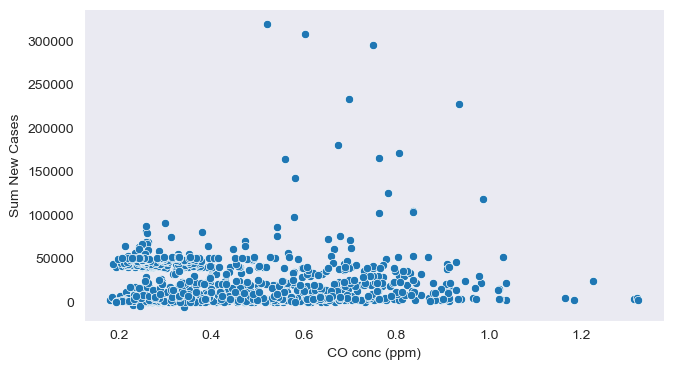

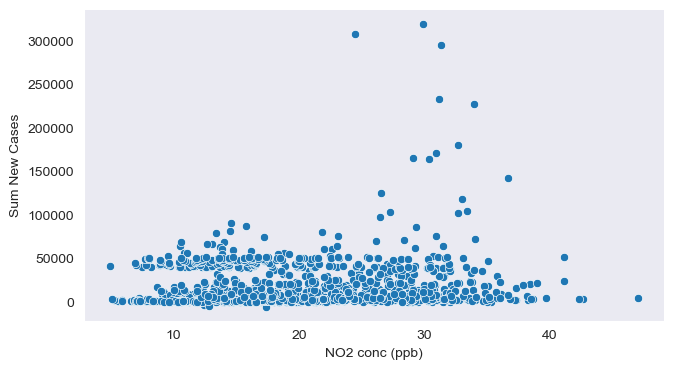

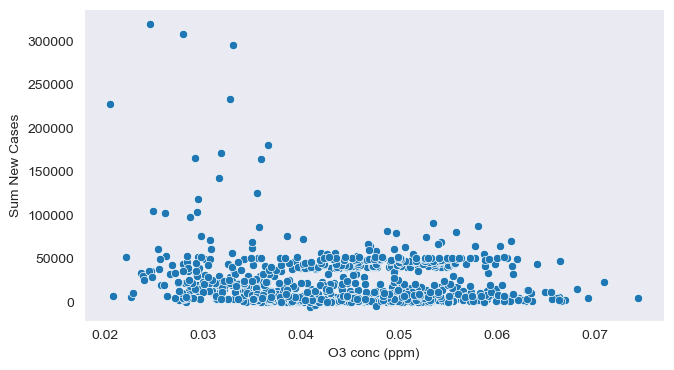

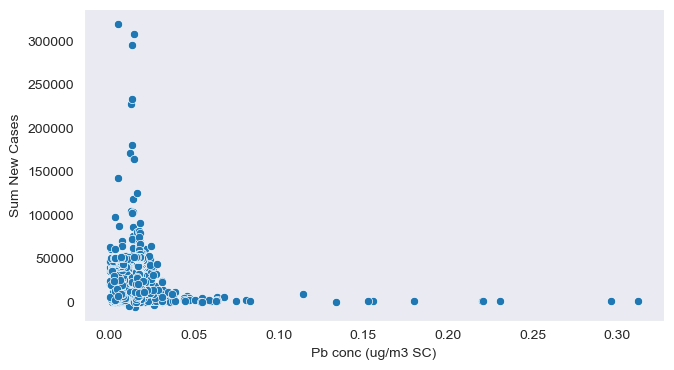

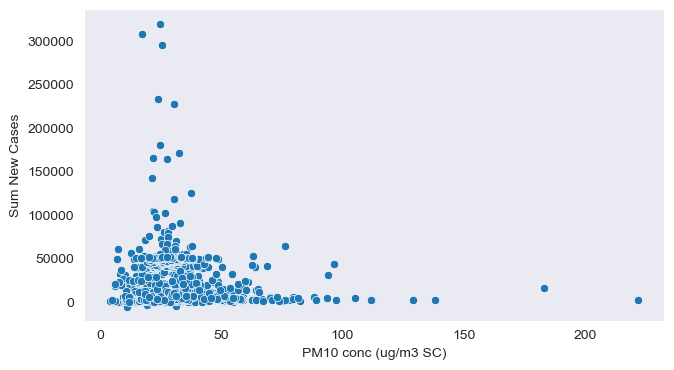

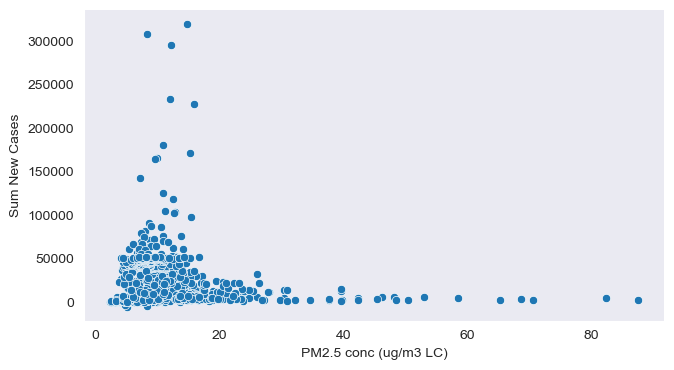

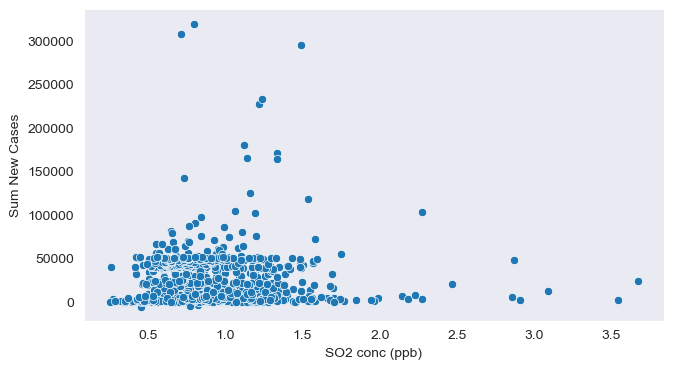

In [2251]:
import matplotlib.pyplot as plt
%matplotlib inline

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
print("Scatterplots before pruning:")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining BEFORE pruning:", data.shape[0])

Upon viewing the scatterplots from above, we find that there are samples that are highly likely to be *anomalies.*
Using this information, let us prune our samples and also drop columns that don't really contribute much to our purposes.

##### Pruning and dropping happens below
It happens below.

Scatterplots after pruning


Number of entries remaining AFTER pruning: 713


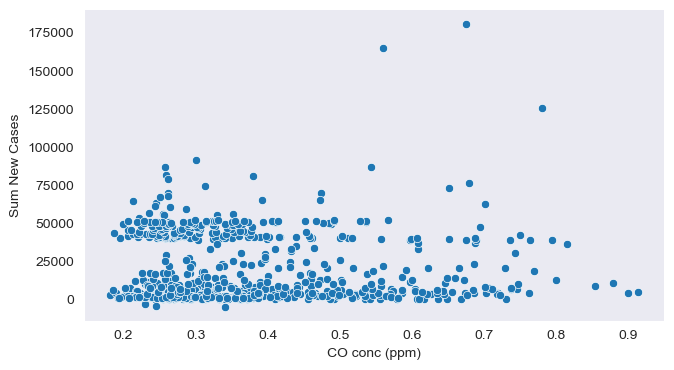

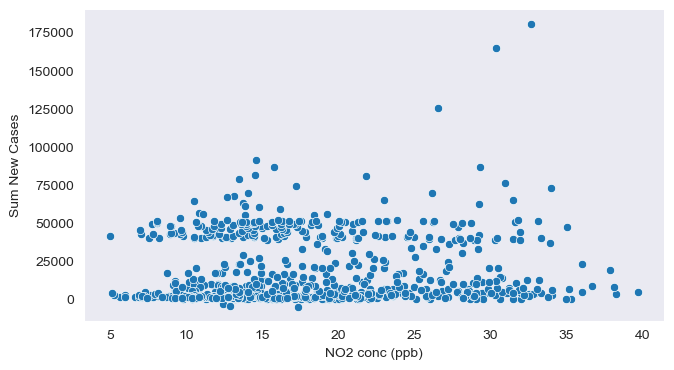

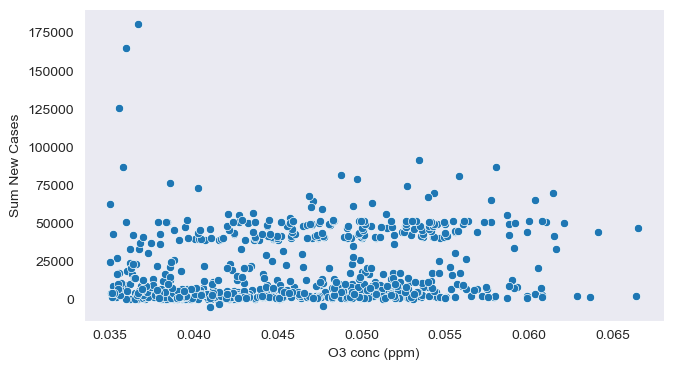

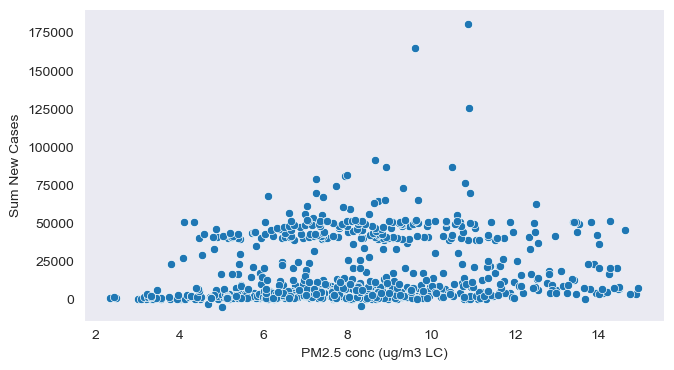

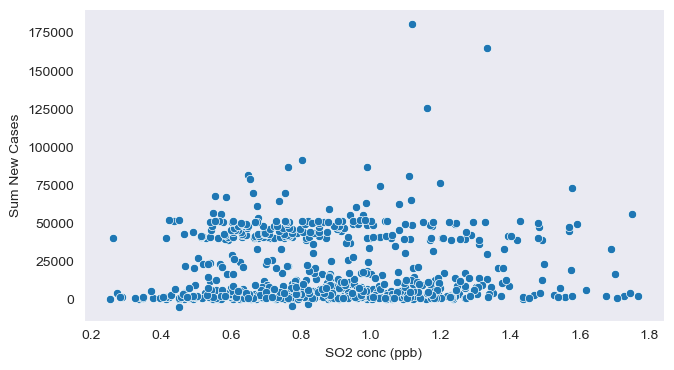

In [2252]:
# DYNAMIC PRUNING
# IDEA: We focus on ambient level of pollutants and ignore sudden spikes in COVID-19 case data (i.e. data dumps).
# We also remove Dates where there are no new infections as their volume skews the data alot.
# Currently visible values are most likely plateaus after painstaking tuning.
# data = data[(data['Sum New Cases'] <= 73000) & (data['Sum New Cases'] > 1)]
data = data[(data['Total Cases'] > 0)]
data = data[(data['Confirmed Cases'] > 0)]
data = data[data['CO conc (ppm)'] <= 1.5]
# data = data[data['NO2 conc (ppb)'] > 1]   # pruning based on some columns hurts the metrics
data = data[data['O3 conc (ppm)'] > 0.035]
data = data[data['Pb conc (ug/m3 SC)'] < 0.5]
data = data[data['PM10 conc (ug/m3 SC)'] < 100]
data = data[data['PM2.5 conc (ug/m3 LC)'] < 15]
data = data[data['SO2 conc (ppb)'] < 2.0]

# DROP COLUMNS HERE
data.drop(columns=['PM10 conc (ug/m3 SC)'], axis=1, inplace=True)
# data = data[['PM10 conc (ug/m3 SC)', 'Sum New Cases']]

# SHOW scatterplots of pruned columns
print("Scatterplots after pruning")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining AFTER pruning:", data.shape[0])

## Regression Plots with 95% Confidence Interval
This contains regression plots of each column in the feature matrix (except for Total Cases) with the target vector (Sum New Cases). This helps visualize the eventual regression (correlation) line that we'll use.

Note that these plots are very helpful when we're trying to decide what columns to use and what to prune.
We can go back and revise our feature matrix using the knowledge we get here.

**IMPORTANT:** Note that in the background, we're keeping `Total Cases` and `Confirmed Cases` as helper features to guide our regression, that is, by combining the air quality with the current total and confirmed cases, we are **trying to predict the new cases**.

<AxesSubplot:xlabel='CO conc (ppm)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='NO2 conc (ppb)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='O3 conc (ppm)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='PM2.5 conc (ug/m3 LC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='SO2 conc (ppb)', ylabel='Sum New Cases'>

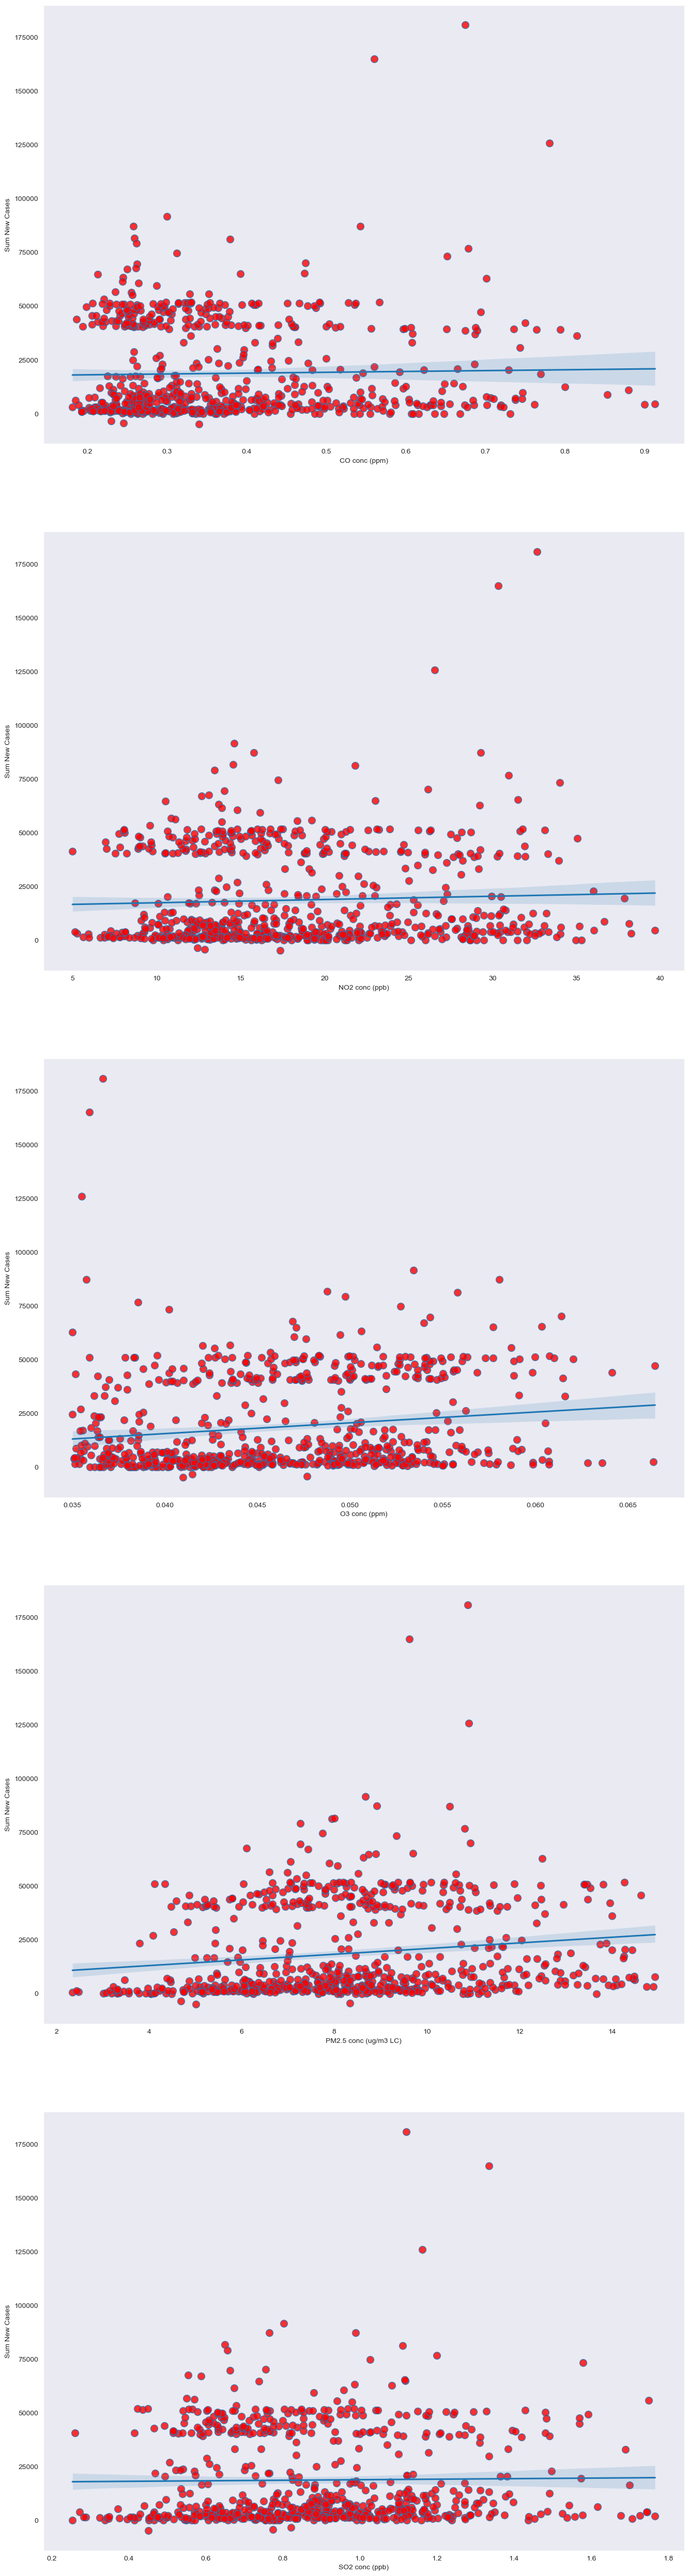

In [2253]:
fig, axs = plt.subplots(nrows=len(data.columns)-3, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label in ["Sum New Cases", "Total Cases", "Confirmed Cases"]: continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

# Modeling: Performing Linear Regression on the Dataset
We begin by standardizing our feature matrix to help our regressor.

Then, we grouped the component of the dataset depending on their classification, whether they are the Target Vector (Sum New Cases) or the Feature Matrix (remaining columns in the dataframe).

Now that we have our x and y, we utilized train_test_split to separate the train data from the test data. Then finally, we started our Linear Regression with the instantiated 'regressor' which we'll use to infer some relationship in the data.

In [2254]:
# Linear Regression
# PREPARE FEATURES AND TARGET DATA (standardize first)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
scaler = MinMaxScaler()

# SPLIT DATA TO FEATURE SET AND TARGET
X = data.iloc[:,0:-1] # feature matrix
X = scaler.fit_transform(X)
y = data.iloc[:,-1] # target vector

# PREPARE TRAINING AND TESTING DATA
# NOTE: test_size is reduced to 20% because we have few records to work with especially after pruning
# (around 499 left from roughly 1000)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
import sklearn.linear_model as sklm
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

LinearRegression()

Coefficients: [  32802.56339221  -31492.59280163    1276.58049819    4576.8957158
    1004.14997269  644414.89096315 -596415.79637716]
Intercept: 3929.1978422041357


**NOTE** that LinearRegression() is not tunable per se, so here, we tried all other models, some of which we denote with `altX`.
We tried and tuned the following (most with high maxa_iter):
1. Logistic Regression
2. Bayesian Ridge Regression
3. Stochastic Gradient Descent (SGD) Regression
4. Elastic Net Regression
5. Huber Regressor
6. ARD Regressor
7. Passive-Aggressive Regressor
8. Gamma Regressor

The best model we got was that of LinearRegression().

### Predictions
This is where we use linear regression to predict values given the test data.

In [2255]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3.69789114e+04, -1.02111862e+03,  1.96335176e+04,  5.27248665e+03,
        1.19989500e+04,  5.04852872e+03,  1.28984948e+04,  1.14879308e+04,
        4.69752080e+04,  5.18284525e+04,  2.42565278e+04,  5.73880296e+03,
        6.42777465e+03,  4.42602191e+04,  3.79161792e+04,  7.27208705e+03,
       -1.08278054e+02,  3.38341940e+03,  4.34244049e+04,  4.72129727e+04,
        3.79877873e+04, -1.67021159e+03,  3.24058540e+04,  3.73189071e+04,
        2.74170860e+03,  1.31437419e+03,  4.31267420e+04,  6.19470519e+03,
        2.86372137e+03,  5.06298003e+04,  2.47764447e+04,  2.03056125e+04,
        5.21908379e+02,  3.90601353e+04,  1.33560980e+04,  1.43624690e+03,
        2.69586053e+04,  3.74697664e+04,  2.95298940e+04,  4.72555063e+04,
       -4.31569205e+01,  3.89380954e+04,  4.27190848e+04,  1.36311145e+03,
        3.08458359e+03,  6.41968309e+03,  6.11617074e+02,  1.19960251e+04,
        7.79224097e+02,  7.34072292e+03,  5.21743308e+03,  1.95254024e+01,
        5.41205464e+03,  

### Comparison of Actual Data with Predicted Data
This is just a side by side comparison of the values of the Actual Data compared with the Predicted Data.

In [2256]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

,Actual,Predicted
Date,,
2022-04-29,26195.000000,36978.911400
2021-02-12,10059.000000,-1021.118616
2021-09-12,9045.000000,19633.517578
2020-02-13,1.000000,5272.486647
2021-08-04,8552.000000,11998.950033
...,...,...
2022-02-02,25550.000000,33029.648534
2020-03-11,20.000000,634.417445
2020-08-17,6469.000000,6412.248465


### Residuals
This contains the difference between the actual value of the data with the predicted data value.

In [2257]:
residuals = y_test - y_pred
residuals

Date
2022-04-29   -10783.911400
2021-02-12    11080.118616
2021-09-12   -10588.517578
2020-02-13    -5271.486647
2021-08-04    -3446.950033
                  ...     
2022-02-02    -7479.648534
2020-03-11     -614.417445
2020-08-17       56.751535
2022-08-24     4007.883934
2022-10-13   -28887.420748
Name: Sum New Cases, Length: 143, dtype: float64

### Plotting of Actual Data with Predicted Data
This is a simple scatter plot of the Actual Data with the Predicted Data.

<AxesSubplot:xlabel='Sum New Cases'>

Text(0.5, 0, 'y_test data')

Text(0, 0.5, 'Predictions')

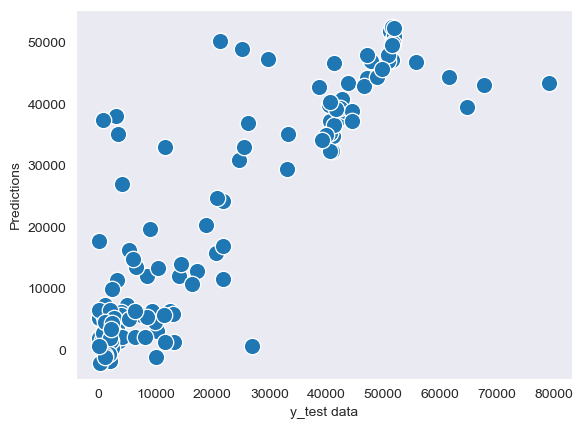

In [2258]:
sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

## Metrics Log
This contains the metric values output of the model when used on the merged dataset.
The scores are logged to a file named `log.out`.

In [2259]:
f = open("log.out", "a")

from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))
dump = f.write('MAE: {}\n'.format(mean_absolute_error(y_test,y_pred)))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))
dump = f.write('MSE: {}\n'.format(mean_squared_error(y_test,y_pred)))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
dump = f.write('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric
dump = f.write('R2 Score: {}\n'.format(r2))

dump = f.write('---\n')

MAE: 5784.789353769572
MSE 89261144.37323454
RMSE 9447.811618212681
R2 Score: 0.783331950116246


Unfortunately, our forecast is pretty far off from the actual recorded data, with high RMSE, but an R2 score of above 60% seems good enough for an exploration. From online sources, a score above 60% is good for empirical sciences, and a score above 50% is good for social sciences. Moreover, there are a lot of caveats in Regression Analysis, and one of those is the context of the research, i.e. if it's working on pre-established relationships or are trying to discover new ones. The latter applies to us.
- [https://www.researchgate.net/post/what_is_the_acceptable_r-squared_value](https://www.researchgate.net/post/what_is_the_acceptable_r-squared_value)
- [https://statisticsbyjim.com/regression/interpret-r-squared-regression/](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

# Alternative Model: Support Vector Regression (SVR)
We also attempt to improve on our Linear Regression metrics by alternatively using Support Vector Regression.

In [2260]:
data = data.reset_index()
NewData = data
NewData

,Date,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Confirmed Cases,Sum New Cases
0,2020-02-02,0.731325,20.180833,0.038462,8.592361,1.094737,3.0,3.0,3.000000
1,2020-02-03,0.282000,18.041969,0.038169,4.044853,0.338028,6.0,6.0,3.000000
2,2020-02-04,0.416250,24.623529,0.036862,5.420280,0.570000,6.0,6.0,3948.723923
3,2020-02-06,0.719540,32.938281,0.035468,11.627586,1.745000,6.0,6.0,3948.723923
4,2020-02-09,0.381466,19.470383,0.037292,8.596011,0.272973,6.0,6.0,3948.723923
...,...,...,...,...,...,...,...,...,...
708,2022-10-14,0.349091,16.385238,0.044713,13.642446,0.533607,11309237.0,10458792.0,7142.000000
709,2022-10-15,0.298507,12.637168,0.042880,7.046203,0.423077,11309237.0,10458792.0,51843.329471
710,2022-10-16,0.330882,16.012174,0.039602,8.195031,0.450000,11309237.0,10458792.0,51843.329471
711,2022-10-17,0.491566,23.882171,0.044470,9.379365,0.969231,11309237.0,10458792.0,51843.329471


In [2261]:
## Perform regression modeling via SVR
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Convert datetime to int
#x = df_chatter['date'].astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.values.reshape(-1, 1)

#y = df_chatter['count']
x = NewData['O3 conc (ppm)']
x = x.values.reshape(-1, 1)
y = NewData['Sum New Cases']
#--------------------------------------------------------------
# SVR model with hyperparameter optimization
#--------------------------------------------------------------
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler and SVR
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svr', SVR(kernel='rbf'))])

# Define the parameter grid for hyperparameter optimization
param_grid = {'svr__C': [10000, 1000000, 100],
              'svr__gamma': [10, 1000, 100]}
# param_grid = {'svr__C': [100, 1000, 100],
#               'svr__gamma': [1, 1000, 100]}

# Perform grid search with cross-validation on train data
grid_search = GridSearchCV(pipeline, param_grid)
grid_search.fit(x_train, y_train)

# Predict using best model on test data
best_svr = grid_search.best_estimator_
y_svr_pred_test = best_svr.predict(x_test)

# Calculate R2 and RMSE for SVR model
svr_r2 = r2_score(y_test, y_svr_pred_test)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_svr_pred_test))

print("Model Evaluation")
print("\nSupport Vector Regression: RMSE=%.2f, R2=%.2f" % (svr_rmse, svr_r2))
print("Hyperparameters:", best_svr, "\n")

# Plot the model
import plotly.graph_objects as go

xtt = NewData['O3 conc (ppm)']#df_chatter['date'].dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

y_svr_pred = best_svr.predict(x) # Plot on all data
line_svr = go.Scatter(x=xtt, y=y_svr_pred, mode='lines', name='SVR', line=dict(color='red'))

data = [scatter_actual, line_regression, line_svr]

layout = go.Layout(xaxis=dict(title='O3 conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression vs. SVR for COVID-19 New Cases & O3 conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [10000, 1000000, 100],
                         'svr__gamma': [10, 1000, 100]})

Model Evaluation

Support Vector Regression: RMSE=23907.48, R2=-0.23
Hyperparameters: Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=10000, gamma=100))]) 



NameError: name 'y_linear_pred' is not defined

# Showing Significant Relationships

In [ ]:
# For CO conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['CO conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['CO conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='CO conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & CO conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
# For NO2 conc (ppb) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['NO2 conc (ppb)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['NO2 conc (ppb)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='NO2 conc (ppb)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & NO2 conc (ppb)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
# For O3 conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)
x = NewData['O3 conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['O3 conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='O3 conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & O3 conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

# Conclusions
Ou there is a relation, but it is highly likely that the model just doesn't have enough data to train on, and that's crucial especially since it's a regressor
Hence our future recommendation to revisit other states together with California

Future Recommendations
- Try using more advanced regression models such as Ecological Regression.
- In the interest of time, we've limited ourselves to just a single location, California. But to add more variables to the regression, which is said to generally improve it, do not just limit yourself to one geographical area, but rather work on . Use the same EPA website to download the data from all the other states, and then use our same dataB but grouped by according to state and date.